## Import libraries

In [133]:
import random 
import os 
import numpy as np

import pandas as pd

from PIL import Image 
from sklearn.model_selection import train_test_split


import torch 
import torchvision.transforms as T

import matplotlib.pyplot as plt
import cv2

## Uploading datas 

In [199]:
# Set the path to the folder containing the images
path = '/Users/af/Documents/Muscle segmentation/300_RF_train_data' #change with path

# Initialize empty lists to store the images
masks = []
images = []
dw_model = 0  #this is needed after to train or not train the model

# Loop through all the files in the folder
for filename in os.listdir(path):
    # Check if the file is an image (has .jpg or .png or .jpeg extension)
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        # Open the image
        image = Image.open(os.path.join(path, filename))
        #image = image.convert('L')    #convert the image to b&W   

        # Check if the filename contains 'mask'
        if 'mask' in filename:
            masks.append(image)
        else:
            images.append(image)
      
    #download models
    if filename == "unet.pth":
        dw_model = torch.load(path + "/" +  filename)
    
    if filename == "unet++.pth":
        plusplus_model = torch.load(path + "/" +  filename)
        
    if filename == "unet3+.pth":
        plusplusplus_model = torch.load(path + "/" +  filename)


# Print the number of images in each list
print(f"Number of images with mask: {len(masks)}")
print(f"Number of images without mask: {len(images)}")

Number of images with mask: 300
Number of images without mask: 300


## Data Preprocessing

In [93]:
#resizing images for tensor
for i in range(len(masks)):
    masks[i] = T.Resize([256, 256])(masks[i])
    images[i] = T.Resize([256, 256])(images[i])


In [94]:
masks = [np.asarray(i) for i in masks]
images =[np.asarray(i) for i in images]

In [95]:
#keeping only the first color layer, since the images are black and white
for i in range(len(masks)):
    masks[i] =  masks[i][:,:,0]
    images[i] = images[i][:,:,0]

In [96]:
#pointless, just for the future code implementation
masks_data, image_data = masks,images

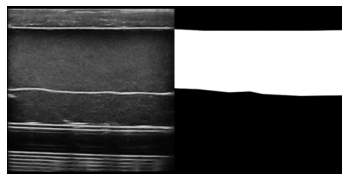

In [97]:
#image visualization
plt.axis('off')
img = images[0]
msk = masks[0]

plt.imshow( np.concatenate([img, msk], axis = 1), cmap= "gray")

In [98]:
#check if size is correct
assert masks_data[0].shape, image_data[0].shape == ((256, 256), (256, 256))

In [99]:
# creating train and test out of the 300 images
X_train, X_test, y_train, y_test = train_test_split(image_data, masks_data,
                                                    test_size = .2, train_size=None,
                                                    random_state=42)

## Models

In [100]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

In [101]:
#creating IOU metric function for binary images
def iou(component1,component2):

  #works only for images with just 0 and 255

    overlap = component1*component2 # Logical AND
    union = component1 + component2 # Logical OR

    IOU = overlap.sum()/float(union.sum()) 
    return IOU

In [268]:
#define a train function for all models
def train(model, train_loader = train_loader, model_trained = True, file_name ="unet.pth", optimizer = optimizer ):
 
    if model_trained != True:
        for epoch in range(num_epochs):
            # Set the model to train mode
            model.train()

            # Train the model on the training data
            train_loss = 0
            i = 1
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)

                #print to see at what point is the algo
                if i %20 == 0:  
                    print(i)


                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)
                i+=1
            train_loss /= len(train_loader.dataset)


            # Evaluate the model on the test data
            model.eval()
            with torch.no_grad():
                test_loss = 0
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    test_loss += loss.item() * inputs.size(0)
                test_loss /= len(test_loader.dataset)

            # Print the epoch and the train and test loss
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        
        torch.save(model.state_dict(), file_name)
            
    else:
        print("It appears that the model is already trained, if you want to overwrite the weights please use the argument model_trained = False")

In [297]:
#load the test and create a list with the masks
def create_masks(model,test_loader = test_loader):
    masks= []
    with torch.no_grad():
        for inputs, targets in test_loader:
            predicted_mask = model(inputs)
            masks.append((predicted_mask,targets,inputs))
    return masks

In [206]:
def test_output(model, masks, show_all = False, thre = True):
    #test the model and print the output compared to the real masks
    model.eval()


    avg_iou = 0
    value = 0

    # Convert the predicted mask and ground truth mask to numpy arrays
    for predicted_mask in masks:
        sample_input = predicted_mask[2]
        sample_mask = predicted_mask[1].detach().numpy()
        predicted_mask = predicted_mask[0].detach().numpy()

        # Create the mask using values 0 and 255 --> todo: check if is it possible to have as the unet ouput 1 or 0
        if thre:
            copia = predicted_mask[0,0].copy()
            copia[copia > 2.0] = 255     #5.2 found with gridsearch in next cel, but use 2 because is better 
            copia[copia <= 2.0] = 0

            avg_iou += iou(copia, sample_mask[0, 0])

            copia2 = predicted_mask[0,0].copy().astype(np.uint8)
            im_blur = cv2.GaussianBlur(copia2,(5,5),0)
            th_blur_otsu, im_seg_semantic = cv2.threshold(im_blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

            a = [im_seg_semantic == 255]
            im_seg_semantic[im_seg_semantic == 0] = 255
            im_seg_semantic[a] = 0



            # Plot the input image, ground truth mask, and predicted mask
            if value < 6 or show_all == True:     #remove this if you want to visualize all masks.

                fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 5))
                axes[0].imshow(np.transpose(sample_input[0], (1, 2, 0)),cmap= 'gray')
                axes[0].set_title("Input Image")
                axes[1].imshow(sample_mask[0, 0], cmap='gray')
                axes[1].set_title("Ground Truth Mask")
                axes[2].imshow(predicted_mask[0, 0], cmap='gray')
                axes[2].set_title("Predicted Mask")
                axes[3].imshow(copia, cmap='gray')
                axes[3].set_title("Predicted average Mask")
                axes[4].imshow(im_seg_semantic, cmap='gray')
                axes[4].set_title("Predicted OTSU Mask")
                plt.show()
                
        #if not just show the original mask
        # Plot the input image, ground truth mask, and predicted mask
        else:
            if value < 6 or show_all == True:     #remove this if you want to visualize all masks.

                    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
                    axes[0].imshow(np.transpose(sample_input[0], (1, 2, 0)),cmap= 'gray')
                    axes[0].set_title("Input Image")
                    axes[1].imshow(sample_mask[0, 0], cmap='gray')
                    axes[1].set_title("Ground Truth Mask")
                    axes[2].imshow(predicted_mask[0, 0], cmap='gray')
                    axes[2].set_title("Predicted Mask")

                    plt.show()
        

        value += 1

    avg_iou = avg_iou/len(masks)
    print(f"IOU for {type(model).__name__} is {avg_iou}")

In [229]:
def tuning(masks,model,x_values = [round(x * 0.1, 1) for x in range(-30, 70)]):
    #find the best threshold value
    best_iou = 0
    best_thres = "no"

    #TO-DO : make it more efficient by calculatin OTSU just for one x
    # Convert the predicted mask and ground truth mask to numpy arrays
    for x in x_values:
        avg_iou = 0
        avg_otsu_iou = 0
        for predicted_mask in masks:
            sample_input = predicted_mask[2]
            sample_mask = predicted_mask[1].detach().numpy()
            predicted_mask = predicted_mask[0].detach().numpy()

            # Create the mask using values 0 and 1 --> todo: check if is it possible to have as the unet ouput 1 or 0
            copia = predicted_mask[0,0].copy()
            copia[copia > x] = 255
            copia[copia <= x] = 0

            copia2 = predicted_mask[0,0].copy().astype(np.uint8)
            im_blur = cv2.GaussianBlur(copia2,(5,5),0)
            th_blur_otsu, im_seg_semantic = cv2.threshold(im_blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

            a = [im_seg_semantic == 255]
            im_seg_semantic[im_seg_semantic == 0] = 255
            im_seg_semantic[a] = 0

            avg_iou += iou(copia, sample_mask[0, 0])
            avg_otsu_iou += iou(im_seg_semantic, sample_mask[0, 0])

        avg_iou = avg_iou/len(masks)
        avg_otsu_iou = avg_otsu_iou/len(masks)
        #print(f"IOU for x == {x} is {avg_iou}")    #uncomment to see value


        if avg_iou > best_iou:
            best_iou = avg_iou
            best_thres = x
    print(f"best x value for {type(model).__name__ } is {best_thres} and is equal to {best_iou} {chr(10)}OTSU thresholding has an IOU of {avg_otsu_iou} that is {'better' if avg_otsu_iou > best_iou else 'worse' }")



In [279]:
# function to compute thickness of the muscle 

def compute_thickness(copia = copia):
    # Find the indices where the consecutive sequences start and end
    avg_length1= 0
    for x in range(len(copia)):
        arr = np.where(copia[:,x] == 255)[0]
        diff_arr = np.diff(arr)
        diff_idx = np.where(diff_arr != 1)[0] + 1
        start_idx = np.insert(diff_idx, 0, 0)
        end_idx = np.append(diff_idx, len(arr))

        # Compute the length of each consecutive sequence
        seq_len = end_idx - start_idx

        # Find the length of the longest consecutive sequence
        avg_length1  += np.max(seq_len)

    return avg_length1 / len(copia)



#the avg_length is in pixelsl, transform in real measure using scale

## U-NET

In [122]:
from UNET1 import build_unet

In [123]:
#creation of the model
model = build_unet()

In [280]:
#If model already trained, download the weights
try:
    dw_model
    model.load_state_dict(dw_model)
    print("U-net model loaded")
except NameError:
    print("No weights found, the model needs to be trained")

U-net model loaded


In [125]:
#set up the model
criterion = nn.BCEWithLogitsLoss() #binary cross entropy as loss
optimizer = optim.SGD(model.parameters(), lr=0.01,
                     momentum=0.9) #stochastic gradient descent optimizer

num_epochs = 1 #to change with more computational power
batch_size = 1 #to changewith more computational power

In [126]:
from Database_class1 import CustomDataset

In [127]:
#creation of the datasets that work with tensors

train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [281]:
#train the model
train(model_pp,file_name = "unet++.pth",optimizer = optimizer)

It appears that the model is already trained, if you want to overwrite the weights please use the argument model_trained = False


In [282]:
#load the test and create a list with the masks
masks= create_masks(model)

<ipython-input-206-c04fbf884372>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  im_seg_semantic[a] = 0


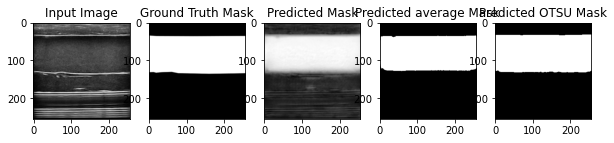

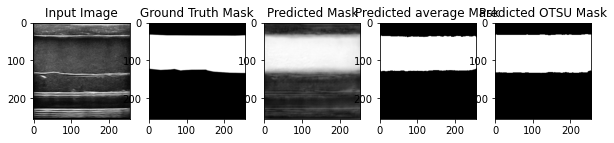

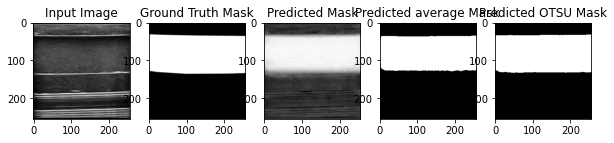

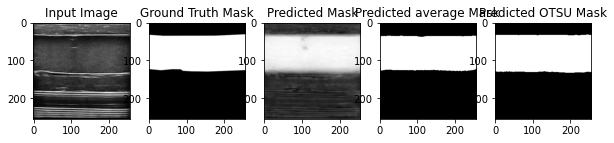

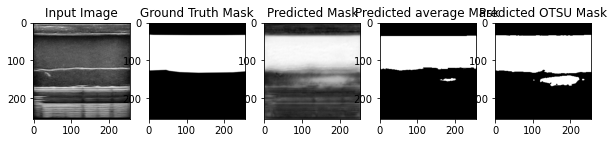

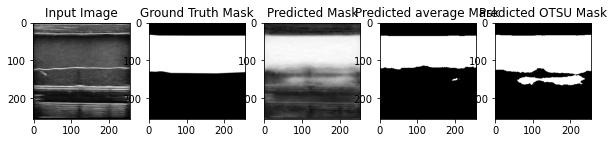

IOU for build_unet is 0.9818736856045205


In [283]:
#test the model and print the output compared to the real masks
test_output(model = model, masks = masks, show_all = False)

In [285]:
#find the best threshold value
tuning(masks = masks_pp,model = model_pp)

<ipython-input-229-cccb7ffd7ae1>:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  im_seg_semantic[a] = 0


best x value for NestedUNet is 3.4 and is equal to 0.9943988880159441 
OTSU thresholding has an IOU of 0.9537216801701215 that is worse


## U-NET ++

In [147]:
from UNET_plusplus import NestedUNet
model_pp = NestedUNet(num_classes=1)

In [159]:
try:
    plusplus_model
    model_pp.load_state_dict(plusplus_model)
    print("U-net ++ model loaded")
except NameError:
    print("No weights found, the model needs to be trained")

U-net ++ model loaded


In [162]:
train(model_pp,file_name = "unet++.pth",optimizer = optim.SGD(model_pp.parameters(), lr=0.01, momentum=0.9))

It appears that the model is already trained, if you want to overwrite the weights please use the argument model_trained = False


In [164]:
masks_pp = create_masks(model_pp)

<ipython-input-175-ab372051bd2a>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  im_seg_semantic[a] = 0


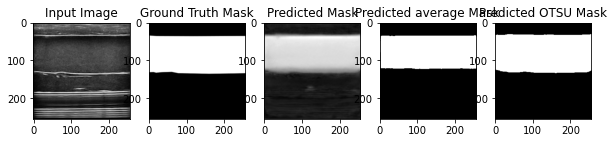

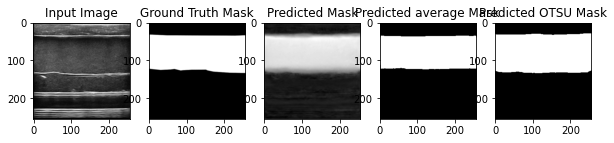

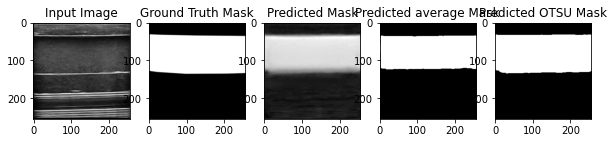

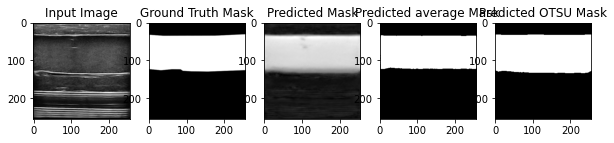

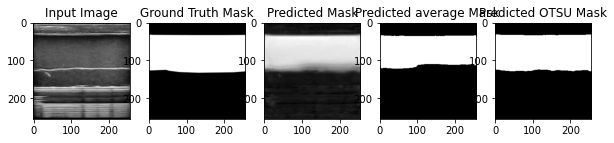

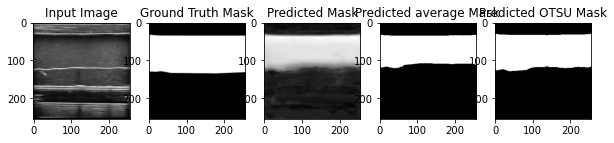

IOU for NestedUNet is 0.990773129298352


In [176]:
test_output(model = model_pp, masks = masks_pp, show_all = False)

In [231]:
tuning(masks = masks_pp,model = model_pp)

<ipython-input-229-cccb7ffd7ae1>:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  im_seg_semantic[a] = 0


best x value for NestedUNet is 3.4 and is equal to 0.9943988880159441 
OTSU thresholding has an IOU of 0.9537216801701215 that is worse


## UNET 3 PLUS

In [200]:
from UNET3plus import UNet3Plus

In [201]:
model_3p = UNet3Plus(n_channels=1,n_classes=1)

In [202]:
try:
    plusplusplus_model
    model_3p.load_state_dict(plusplusplus_model)
    print("U-net +++ model loaded")
except NameError:
    print("No weights found, the model needs to be trained")

U-net ++ model loaded


In [203]:
train(model_3p,file_name = "unet3+.pth",optimizer = optim.SGD(model_3p.parameters(), lr=0.01, momentum=0.9))

It appears that the model is already trained, if you want to overwrite the weights please use the argument model_trained = False


In [211]:
#this takes a lot of time
masks_3p = create_masks(model_3p)

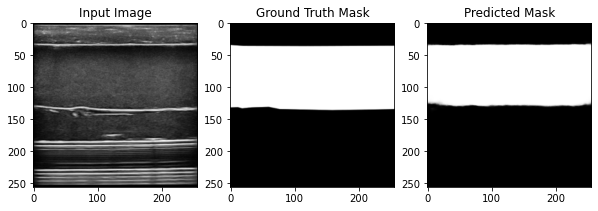

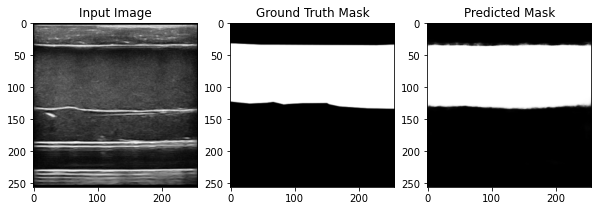

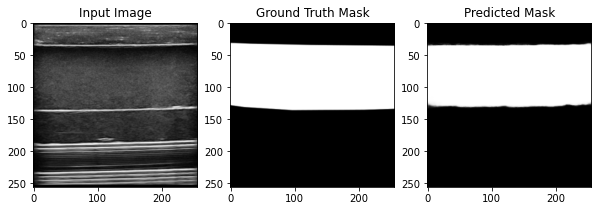

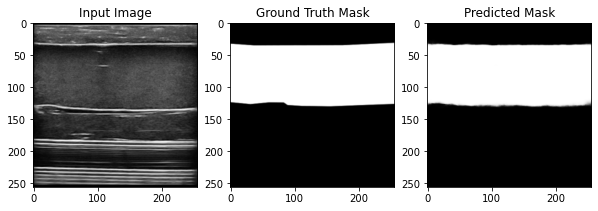

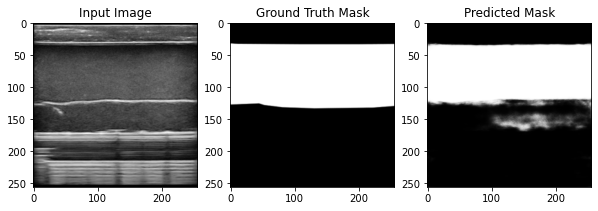

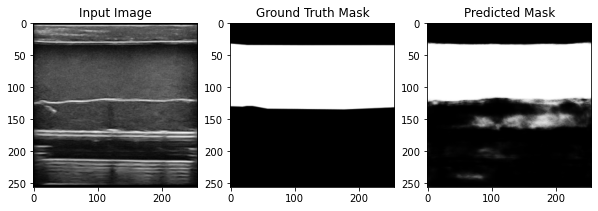

IOU for UNet3Plus is 0.0


In [212]:
test_output(model = model_3p, masks = masks_3p, show_all = False,thre = False)

In [230]:
tuning(masks = masks_3p,model = model_3p,x_values = [0.9,0.91,0.92,0.93,0.94,0.95,0.98,0.9992,0.9993,0.9994])

<ipython-input-229-cccb7ffd7ae1>:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  im_seg_semantic[a] = 0


best x value for UNet3Plus is 0.9994 and is equal to 0.9912063329384789 
OTSU thresholding has an IOU of 0.3739131794842467 that is worse


## FCNN

In [269]:
from fcnn import FCNN

In [270]:
fcnn = FCNN()

In [271]:
try:
    fcnn_model
    fcnn.load_state_dict(fcnn_model)
    print("U-net ++ model loaded")
except NameError:
    print("No weights found, the model needs to be trained")

No weights found, the model needs to be trained


In [272]:
train(fcnn,file_name = "fcnn.pth",model_trained = False, optimizer = optim.SGD(fcnn.parameters(), lr=0.01, momentum=0.9))

20
40
60
80
100
120
140
160
180
200
220
240
Epoch [1/1], Train Loss: 0.4765, Test Loss: 0.3957


In [273]:
masks_fcnn = create_masks(fcnn)

<ipython-input-206-c04fbf884372>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  im_seg_semantic[a] = 0


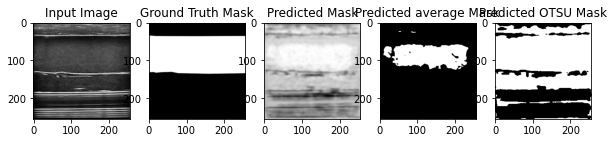

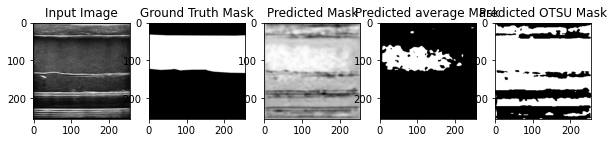

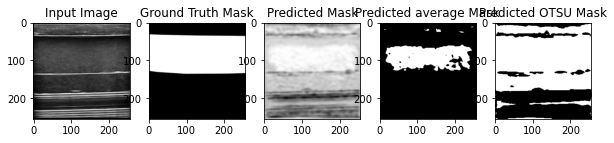

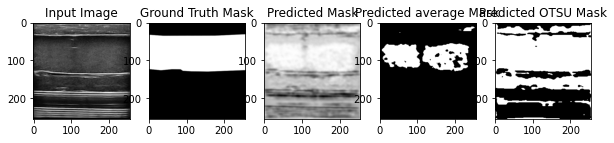

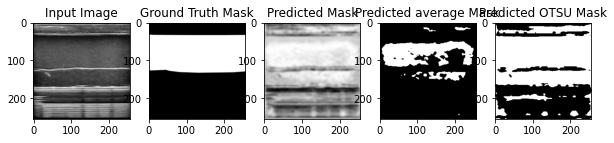

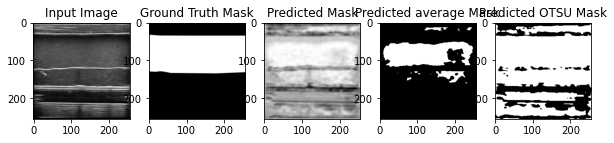

IOU for FCNN is 0.9528405632296503


In [274]:
test_output(model = fcnn, masks = masks_fcnn, show_all = False,thre = True)

In [278]:
tuning(masks = masks_fcnn,model = fcnn,x_values = [round(x * 0.05, 1) for x in range(0, 70)])

<ipython-input-229-cccb7ffd7ae1>:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  im_seg_semantic[a] = 0


best x value for FCNN is 2.4 and is equal to 0.9742514342110319 
OTSU thresholding has an IOU of 0.5674994396100203 that is worse


# Compare final results

In [292]:
# Load unlabled images

path = '/Users/af/Documents/Muscle segmentation/RF_test_data' #change with path
sample_images = []
for filename in os.listdir(path):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        sample_image = Image.open(os.path.join(path, filename))
        sample_images.append(sample_image)

for i in range(len(sample_images)): 
    sample_images[i] = T.Resize([256, 256])(sample_images[i])


In [293]:
sample_images = [np.asarray(i)[:,:,0] for i in sample_images]
sample_images = sample_images[:10] #visualize only first ten

In [294]:
test_dataset1 = CustomDataset(sample_images,sample_images)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)

In [298]:
#run all models

testmasks_fcnn = create_masks(fcnn,test_loader = test_loader1)
testmasks_3p = create_masks(model_3p,test_loader = test_loader1)
testmasks_pp = create_masks(model_pp,test_loader = test_loader1)
testmasks = create_masks(model,test_loader = test_loader1)



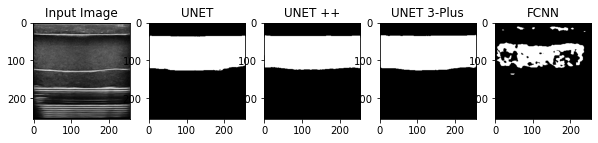

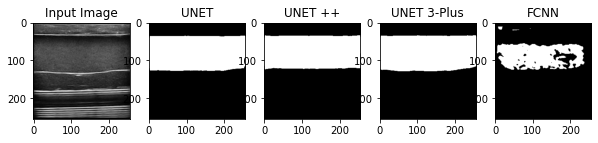

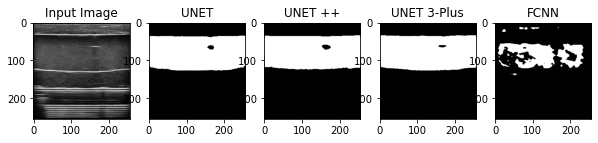

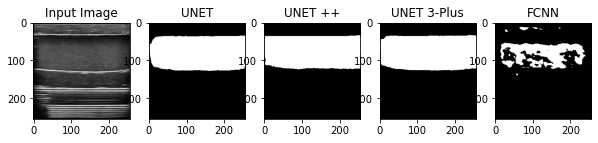

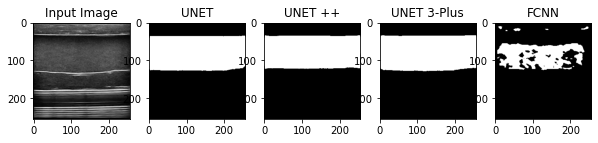

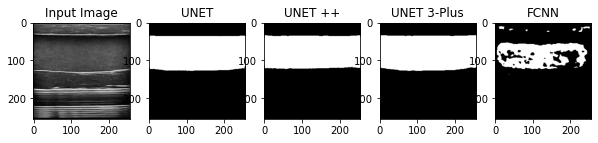

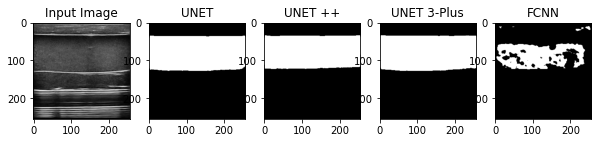

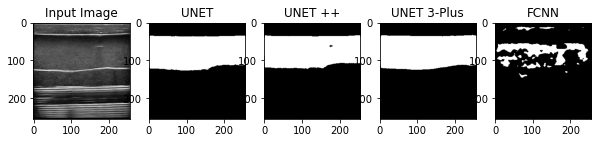

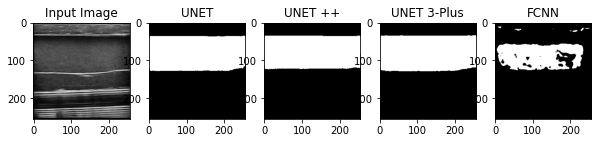

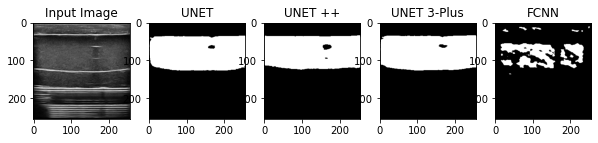

In [310]:
for i in range(10):
    sample_input = testmasks[i][1]
    
    predicted_mask = testmasks[i][0].detach().numpy()

    # Create the mask using values 0 and 1 --> todo: check if is it possible to have as the unet ouput 1 or 0
    copia = predicted_mask[0,0].copy()
    copia[copia > 2] = 255
    copia[copia <= 2] = 0
    
    predicted_mask1 = testmasks_pp[i][0].detach().numpy()

    # Create the mask using values 0 and 1 --> todo: check if is it possible to have as the unet ouput 1 or 0
    copia1 = predicted_mask1[0,0].copy()
    copia1[copia1 > 2] = 255
    copia1[copia1 <= 2] = 0
    
    predicted_mask2 = testmasks_3p[i][0].detach().numpy()

    # Create the mask using values 0 and 1 --> todo: check if is it possible to have as the unet ouput 1 or 0
    copia2 = predicted_mask2[0,0].copy()
    copia2[copia2 > 0.9] = 255
    copia2[copia2 <= 0.9] = 0
    
    predicted_mask3 = testmasks_fcnn[i][0].detach().numpy()

    # Create the mask using values 0 and 1 --> todo: check if is it possible to have as the unet ouput 1 or 0
    copia3 = predicted_mask3[0,0].copy()
    copia3[copia3 > 2] = 255
    copia3[copia3 <= 2] = 0
    
    
    # Plot the input image, ground truth mask, and predicted mask
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 5))
    axes[0].imshow(np.transpose(sample_input[0], (1, 2, 0)), cmap = 'gray')
    axes[0].set_title("Input Image")
    axes[1].imshow(copia, cmap='gray')
    axes[1].set_title("UNET")
    axes[2].imshow(copia1, cmap='gray')
    axes[2].set_title("UNET ++")
    axes[3].imshow(copia2, cmap='gray')
    axes[3].set_title("UNET 3-Plus")
    axes[4].imshow(copia3, cmap='gray')
    axes[4].set_title("FCNN")
    plt.show()
    

In [311]:
#compute the thickness of the muscle of the last image for each model using the function compute_thickness defined above (using the average of each column)
print( f"Muscle thickness for UNET is  {compute_thickness(copia)}")
print( f"Muscle thickness for UNET++ is  {compute_thickness(copia1)}")
print( f"Muscle thickness for UNET3-plus is  {compute_thickness(copia2)}")
print( f"Muscle thickness for FCNN is  {compute_thickness(copia3)}")

Muscle thickness for UNET is  84.62890625
Muscle thickness for UNET++ is  80.5234375
Muscle thickness for UNET3-plus is  84.61328125
Muscle thickness for FCNN is  18.7421875


In [312]:
import numpy as np

def compute_thickness1(copia=copia):
    median_lengths = []
    for x in range(copia.shape[1]):
        arr = np.where(copia[:, x] == 255)[0]
        diff_arr = np.diff(arr)
        diff_idx = np.where(diff_arr != 1)[0] + 1
        start_idx = np.insert(diff_idx, 0, 0)
        end_idx = np.append(diff_idx, len(arr))

        seq_len = end_idx - start_idx
        median_lengths.append(np.max(seq_len))

    return np.median(median_lengths)

In [313]:


print( f"Median Muscle thickness for UNET is  {compute_thickness1(copia)}")
print( f"Median Muscle thickness for UNET++ is  {compute_thickness1(copia1)}")
print( f"Median Muscle thickness for UNET3-plus is  {compute_thickness1(copia2)}")
print( f"Median Muscle thickness for FCNN is  {compute_thickness1(copia3)}")

Muscle thickness for UNET is  89.0
Muscle thickness for UNET++ is  85.0
Muscle thickness for UNET3-plus is  88.0
Muscle thickness for FCNN is  20.0


In [314]:
from scipy.stats import mode

def compute_thickness2(copia):
    mode_lengths = []
    for x in range(copia.shape[1]):
        arr = np.where(copia[:, x] == 255)[0]
        diff_arr = np.diff(arr)
        diff_idx = np.where(diff_arr != 1)[0] + 1
        start_idx = np.insert(diff_idx, 0, 0)
        end_idx = np.append(diff_idx, len(arr))

        seq_len = end_idx - start_idx
        mode_lengths.append(mode(seq_len)[0][0])

    return mode(mode_lengths)[0][0]

In [315]:
print( f"Mode Muscle thickness for UNET is  {compute_thickness2(copia)}")
print( f"Mode Muscle thickness for UNET++ is  {compute_thickness2(copia1)}")
print( f"Mode Muscle thickness for UNET3-plus is  {compute_thickness2(copia2)}")
print( f"Mode Muscle thickness for FCNN is  {compute_thickness2(copia3)}")

Muscle thickness for UNET is  90
Muscle thickness for UNET++ is  86
Muscle thickness for UNET3-plus is  90
Muscle thickness for FCNN is  0


### Using the average to compute the thickness may be wrong, because it does not exclude outliers. As it is possible to se by the last imag, the algorithm uncorrectly classify a small hole as white, so the final result of the thickness is wrong.
### It is more correct to use the Median or the Mode